# Bosch Traffic Light detection

# Imports

In [104]:
from apex import amp
amp_handle = amp.init(enabled=True)
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import yaml
import json
import cv2
import pdb

In [151]:
import fastai
from fastai import *

# Data Exploration

## Importatnt paths

In [164]:
data_path = './Bosch_trafficlight_data'
train_images_path = data_path + '/rgb/train'
test_images_path = data_path + '/rgb/test'
pascal_train_labels_path = data_path + '/train_labels'
pascal_test_labels_path = data_path + '/test_labels'

## Annotation convertion
First of we convert our bboxes labels to the PASCAL V2 standard to make it easier and 
more convenient to deal with.

### Training annotations to json 

In [72]:
!python bosch_to_pascal.py ./Bosch_trafficlight_data/train.yaml ./Bosch_trafficlight_data/ train

### Test annotations to json

In [75]:
!python bosch_to_pascal.py ./Bosch_trafficlight_data/test.yaml ./Bosch_trafficlight_data/ test

In [12]:
# !python bosch_to_pascal.py ./Bosch_trafficlight_data/train.yaml ./Bosch_trafficlight_data/train_labels

In [15]:
#  !python bosch_to_pascal.py ./Bosch_trafficlight_data/test.yaml ./Bosch_trafficlight_data/test_labels

## YAML to Json

In [25]:
# import sys
# import yaml 
# import json

# y = yaml.safe_load(data_path + 'train.yaml')
# print(json.dumps(y))

"./Bosch_trafficlight_data/train.yaml"


In [26]:
# !python -c 'import sys, yaml, json; json.dump(yaml.safe_load(sys.stdin), sys.stdout, indent=4)' < ./Bosch_trafficlight_data/train.yaml > train.json

In [27]:
# !python -c 'import sys, yaml, json; json.dump(yaml.safe_load(sys.stdin), sys.stdout, indent=4)' < ./Bosch_trafficlight_data/test.yaml > ./Bosch_trafficlight_data/test.json

## Now lets take a look at the images 

### Utils

In [138]:

# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
#     xmin, ymin, xmax, ymax = map(int, bbox)
#     locals().update(bbox)
    xmin = int(float(bbox['xmin']))
    xmax = int(float(bbox['xmax']))
    ymax = int(float(bbox['ymax']))
    ymin = int(float(bbox['ymin']))
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (xmin, ymin - int(1.3 * text_height)), (xmin + text_width, ymin), BOX_COLOR, -1)
    cv2.putText(img, class_name, (xmin, ymin - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def load_image(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def visualize(annotations, category_id_to_name):
    im = load_image(annotations['folder'])
    for idx, obj in enumerate(annotations['objects']):
        im = visualize_bbox(im, obj['bndbox'], obj['name'])
    return im

                         
cat_name = 'Traffic Light' # unfortunately this is required by albumentations, we cannot just have bounding box coordinates on their own

## JSON

In [73]:
json_train = json.load(open(data_path + 'train_annotations.json'))

In [160]:
len(json_train)
json_train[3]

{'filename': '207390.png',
 'folder': './Bosch_trafficlight_data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207390.png',
 'objects': [{'bndbox': {'xmax': '615.5',
    'xmin': '612.0',
    'ymax': '360.375',
    'ymin': '354.75'},
   'difficult': '0',
   'name': 'RedLeft',
   'occluded': 'True',
   'pose': 'Unspecified'},
  {'bndbox': {'xmax': '636.625',
    'xmin': '632.25',
    'ymax': '355.375',
    'ymin': '346.375'},
   'difficult': '0',
   'name': 'Red',
   'occluded': 'False',
   'pose': 'Unspecified'},
  {'bndbox': {'xmax': '653.875',
    'xmin': '649.25',
    'ymax': '364.875',
    'ymin': '353.5'},
   'difficult': '0',
   'name': 'Red',
   'occluded': 'False',
   'pose': 'Unspecified'}],
 'segmented': '0',
 'size': {'depth': '3', 'height': '720', 'width': '1280'}}

1100
4662
516
2089
965
4058
3682
3868
3109


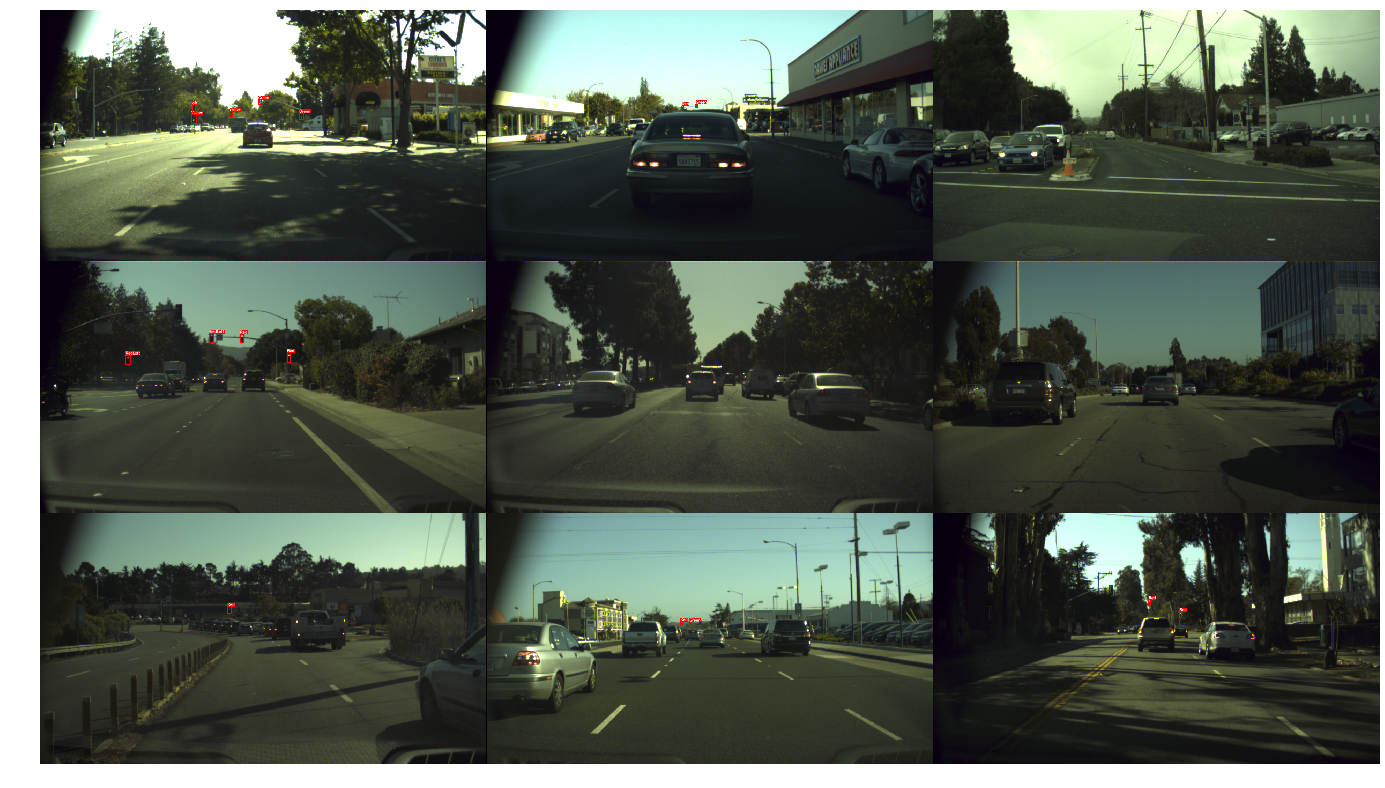

In [149]:
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
idxs = []
# generate some integers
for _ in range(9):
    value = randint(0, len(json_train))
    idxs.append(value)
    print(value)
ims = np.stack([visualize(json_train[i], cat_name) for i in idxs])
plt.figure(figsize=(24,24))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))


## Save to CSV 
Here I'll save the json data to a CSV file

## Image Augmentations

In [159]:
tfms = get_transforms(do_flip=True, max_rotate=3, p_affine=0.5, max_lighting=0.05)
len(tfms[0])

7

### Helper functions

In [189]:
def get_class_ex(): return open_image('./Bosch_trafficlight_data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207390.png')

def get_bb_ex():
    img = open_image('./Bosch_trafficlight_data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207390.png')
    bboxes = [[615, 612, 360, 354], [636, 632,355, 346], [653, 649, 364, 353]]
    print(img.size)
    return img, ImageBBox.create(*img.size, [[615, 612, 360, 354]], labels=[0], classes=['tl'])

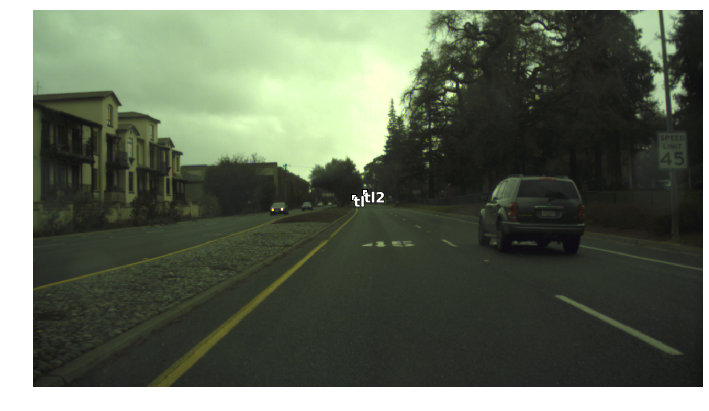

In [210]:

img = open_image('./Bosch_trafficlight_data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207390.png')
bboxes = [[615, 612, 360, 354], [636, 632,355, 346], [653, 649, 364, 353]] 
bbox = ImageBBox.create(*img.size, [[354, 612, 360, 615], [346, 632, 355, 636]], labels=[0, 1], classes=['tl', 'tl2'])
_, axs = plt.subplots(1,1,figsize=(12,12))

img.show(ax=axs, y=bbox)

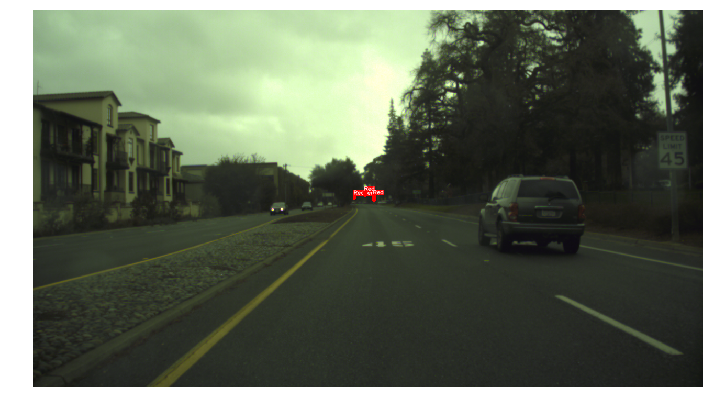

In [206]:
img = visualize(json_train[3], cat_name)
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img)

torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)
torch.Size([720, 1280])
ImageBBox (720, 1280)


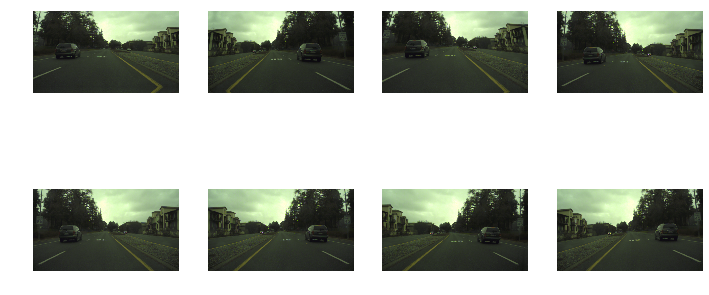

In [193]:
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img,bbox = get_bb_ex()
    print(bbox)
    bbox = img.apply_tfms(tfms[0])
#     bbox = bbox.apply_tfms(tfms[0], do_resolve=False)
    img.show(ax=ax, y=bbox)

## Creating the DataLoader

In [161]:
SZ = 224
BS = 128

In [ ]:
data = ( 
    ImageItemList
        .from_df()
        .random_split_by_pct(seed=42)
        .transform(tfms, tfm_y=True, size=SZ)
)

## Create a dummy SSD model
This model's architecture is gonna be a resnet34 backbone and a custom head

In [211]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, 
                              padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): 
        return self.drop(self.bn(F.relu(self.conv(x))))

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, 
                                padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv1 = StdConv(256, 256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)



In [214]:
f_model = models.resnet34
head_reg4 = SSD_Head(k, -3)
models = create_cnn(f_model, custom_head=head_reg4)

NameError: name 'k' is not defined

## Loss Function 
Jaccard IOU

### Focal Loss


In [216]:
gamma = 2
f_loss = -(1 - p)**gamma * log(p)

NameError: name 'p' is not defined